Implementation of an algorithm to prepare a Gaussian state on a quantum computer, as described in the paper by A. Kitaev and W. Webb: https://arxiv.org/abs/0801.0342. The algorithm below is slightly modified from the original, and replaces the supplementary memory qubits with N-level controlled operations.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pyquil.quil import Program
import pyquil.api as api

In [2]:
def norm_(sigma_, mu_, N):
   """
   Normalization factor for the state. Defined in Eq (7) of paper.
   
   Inputs:-
   sigma_: standard deviation
   mu_: mean
   N: cutoff the for the infinite sum, i.e. sum_{i=-N}^{i=N} (...)
   """
   return np.sum(np.exp((-(np.arange(-N, N+1, 1) - mu_)**2)/float(sigma_**2)))

def angle_(sigma_, mu_, N=10**3):
    """
    The angle $\alpha$ defined in Eq (12)
    """
    return np.arccos(np.sqrt(norm_(sigma_/2., mu_/2., N)/norm_(sigma_, mu_, N)))

In [3]:
quantum_simulator = api.QVMConnection()

### 4 qubits

In [4]:
NN = 4
mu = 8.0
sigma = 3.0

In [5]:
p = Program()

In [6]:
# qubit 0
sigma_0 = sigma
mu_0 = mu
alpha_0 = angle_(sigma_0, mu_0)

In [7]:
# qubit 1
sigma_1 = sigma_0/2.0
mu_10 = mu_0/2.0
mu_11= (mu_0 - 1.0)/2.0
alpha_10 = angle_(sigma_1, mu_10)
alpha_11 = angle_(sigma_1, mu_11)

In [8]:
# qubit 2
sigma_2 = sigma/4.
mu_2_0 = mu/4.
mu_2_1 = ((mu/2.) - 1.)/2.
mu_2_2 = ((mu - 1.)/2.)/2.
mu_2_3 = (((mu - 1.)/2.) - 1)/2.

In [9]:
alpha_2_0 = angle_(sigma_2, mu_2_0)
alpha_2_1 = angle_(sigma_2, mu_2_1)
alpha_2_2 = angle_(sigma_2, mu_2_2)
alpha_2_3 = angle_(sigma_2, mu_2_3)

In [10]:
# qubit 3
sigma_3 = sigma/8.
mu_3_0 = ((mu/2.)/2.)/2.
mu_3_1 = (((mu/2.)/2.) - 1.)/2.
mu_3_2 = (((mu/2.) - 1.)/2.)/2.
mu_3_3 = ((((mu/2.) - 1.)/2.) - 1.)/2.
mu_3_4 = (((mu - 1.)/2.)/2.)/2.
mu_3_5 = ((((mu - 1.)/2.)/2.) - 1.)/2.
mu_3_6 = ((((mu - 1.)/2.) - 1.)/2.)/2.
mu_3_7 = (((((mu - 1.)/2.) - 1.)/2.) - 1.)/2.

In [11]:
alpha_3_0 = angle_(sigma_3, mu_3_0)
alpha_3_1 = angle_(sigma_3, mu_3_1)
alpha_3_2 = angle_(sigma_3, mu_3_2)
alpha_3_3 = angle_(sigma_3, mu_3_3)
alpha_3_4 = angle_(sigma_3, mu_3_4)
alpha_3_5 = angle_(sigma_3, mu_3_5)
alpha_3_6 = angle_(sigma_3, mu_3_6)
alpha_3_7 = angle_(sigma_3, mu_3_7)

In [12]:
level_0_gate = np.array([[np.cos(alpha_0), -np.sin(alpha_0)], [np.sin(alpha_0), np.cos(alpha_0)]])

In [13]:
level_1_gate = np.array([[np.cos(alpha_10), -np.sin(alpha_10), 0, 0],
                    [np.sin(alpha_10), np.cos(alpha_10), 0, 0],
                    [0, 0, np.cos(alpha_11), -np.sin(alpha_11)],
                    [0, 0, np.sin(alpha_11), np.cos(alpha_11)]])

In [14]:
level_2_gate = np.array(
    [[np.cos(alpha_2_0), -np.sin(alpha_2_0), 0, 0, 0, 0, 0, 0],
     [np.sin(alpha_2_0), np.cos(alpha_2_0), 0, 0, 0, 0, 0, 0],
     [0, 0, np.cos(alpha_2_1), -np.sin(alpha_2_1), 0, 0, 0, 0],
     [0, 0, np.sin(alpha_2_1), np.cos(alpha_2_1), 0, 0, 0, 0],
     [0, 0, 0, 0, np.cos(alpha_2_2), -np.sin(alpha_2_2), 0, 0],
     [0, 0, 0, 0, np.sin(alpha_2_2), np.cos(alpha_2_2), 0, 0],
     [0, 0, 0, 0, 0, 0, np.cos(alpha_2_3), -np.sin(alpha_2_3)],
     [0, 0, 0, 0, 0, 0, np.sin(alpha_2_3), np.cos(alpha_2_3)]])

In [15]:
level_3_gate = np.array(
    [[np.cos(alpha_3_0), -np.sin(alpha_3_0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [np.sin(alpha_3_0), np.cos(alpha_3_0), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, np.cos(alpha_3_1), -np.sin(alpha_3_1), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, np.sin(alpha_3_1), np.cos(alpha_3_1), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, np.cos(alpha_3_2), -np.sin(alpha_3_2), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, np.sin(alpha_3_2), np.cos(alpha_3_2), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, np.cos(alpha_3_3), -np.sin(alpha_3_3), 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, np.sin(alpha_3_3), np.cos(alpha_3_3), 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, np.cos(alpha_3_4), -np.sin(alpha_3_4), 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, np.sin(alpha_3_4), np.cos(alpha_3_4), 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.cos(alpha_3_5), -np.sin(alpha_3_5), 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.sin(alpha_3_5), np.cos(alpha_3_5), 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.cos(alpha_3_6), -np.sin(alpha_3_6), 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.sin(alpha_3_6), np.cos(alpha_3_6), 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.cos(alpha_3_7), -np.sin(alpha_3_7)],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.sin(alpha_3_7), np.cos(alpha_3_7)]]
)

In [16]:
p.defgate("Level_0_gate", level_0_gate)
p.defgate("Level_1_gate", level_1_gate)
p.defgate("Level_2_gate", level_2_gate)
p.defgate("Level_3_gate", level_3_gate)

In [17]:
p.inst(("Level_0_gate", 0))
p.inst(("Level_1_gate", 0, 1))
p.inst(("Level_2_gate", 0, 1, 2))
p.inst(("Level_3_gate", 0, 1, 2, 3))

In [18]:
wavefunction = quantum_simulator.wavefunction(p)
print (wavefunction.get_outcome_probs())

{'0000': 0.00030691455789959418, '0001': 0.00083568687856302906, '0010': 0.0034473082271214389, '0011': 0.011693388287512227, '0100': 0.031785205174715767, '0101': 0.069184584219319292, '0110': 0.12058243217460905, '0111': 0.16828634050116659, '1000': 0.18806319451608564, '1001': 0.1682863405011667, '1010': 0.12058243217460914, '1011': 0.069184584219319292, '1100': 0.031785205174715787, '1101': 0.011693388287512227, '1110': 0.0034473082271214424, '1111': 0.00083568687856305421}


In [19]:
wavefcn_xlist = list(wavefunction.get_outcome_probs().keys())
wavefcn_ylist = list(wavefunction.get_outcome_probs().values())

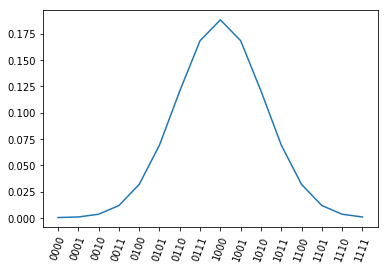

In [20]:
plt.plot(range(len(wavefcn_ylist)), wavefcn_ylist)
plt.xticks(range(len(wavefcn_xlist)), wavefcn_xlist, rotation=70)
plt.show()